In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e14/sample_submission.csv
/kaggle/input/playground-series-s3e14/train.csv
/kaggle/input/playground-series-s3e14/test.csv


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
plt.style.use('ggplot')

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s3e14/train.csv').drop('id',axis = 1)
test = pd.read_csv('/kaggle/input/playground-series-s3e14/test.csv').drop('id',axis = 1)

In [5]:
df = train.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15289 entries, 0 to 15288
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   clonesize             15289 non-null  float64
 1   honeybee              15289 non-null  float64
 2   bumbles               15289 non-null  float64
 3   andrena               15289 non-null  float64
 4   osmia                 15289 non-null  float64
 5   MaxOfUpperTRange      15289 non-null  float64
 6   MinOfUpperTRange      15289 non-null  float64
 7   AverageOfUpperTRange  15289 non-null  float64
 8   MaxOfLowerTRange      15289 non-null  float64
 9   MinOfLowerTRange      15289 non-null  float64
 10  AverageOfLowerTRange  15289 non-null  float64
 11  RainingDays           15289 non-null  float64
 12  AverageRainingDays    15289 non-null  float64
 13  fruitset              15289 non-null  float64
 14  fruitmass             15289 non-null  float64
 15  seeds              

# EDA

Text(0.5, 0.98, 'Features Histogram')

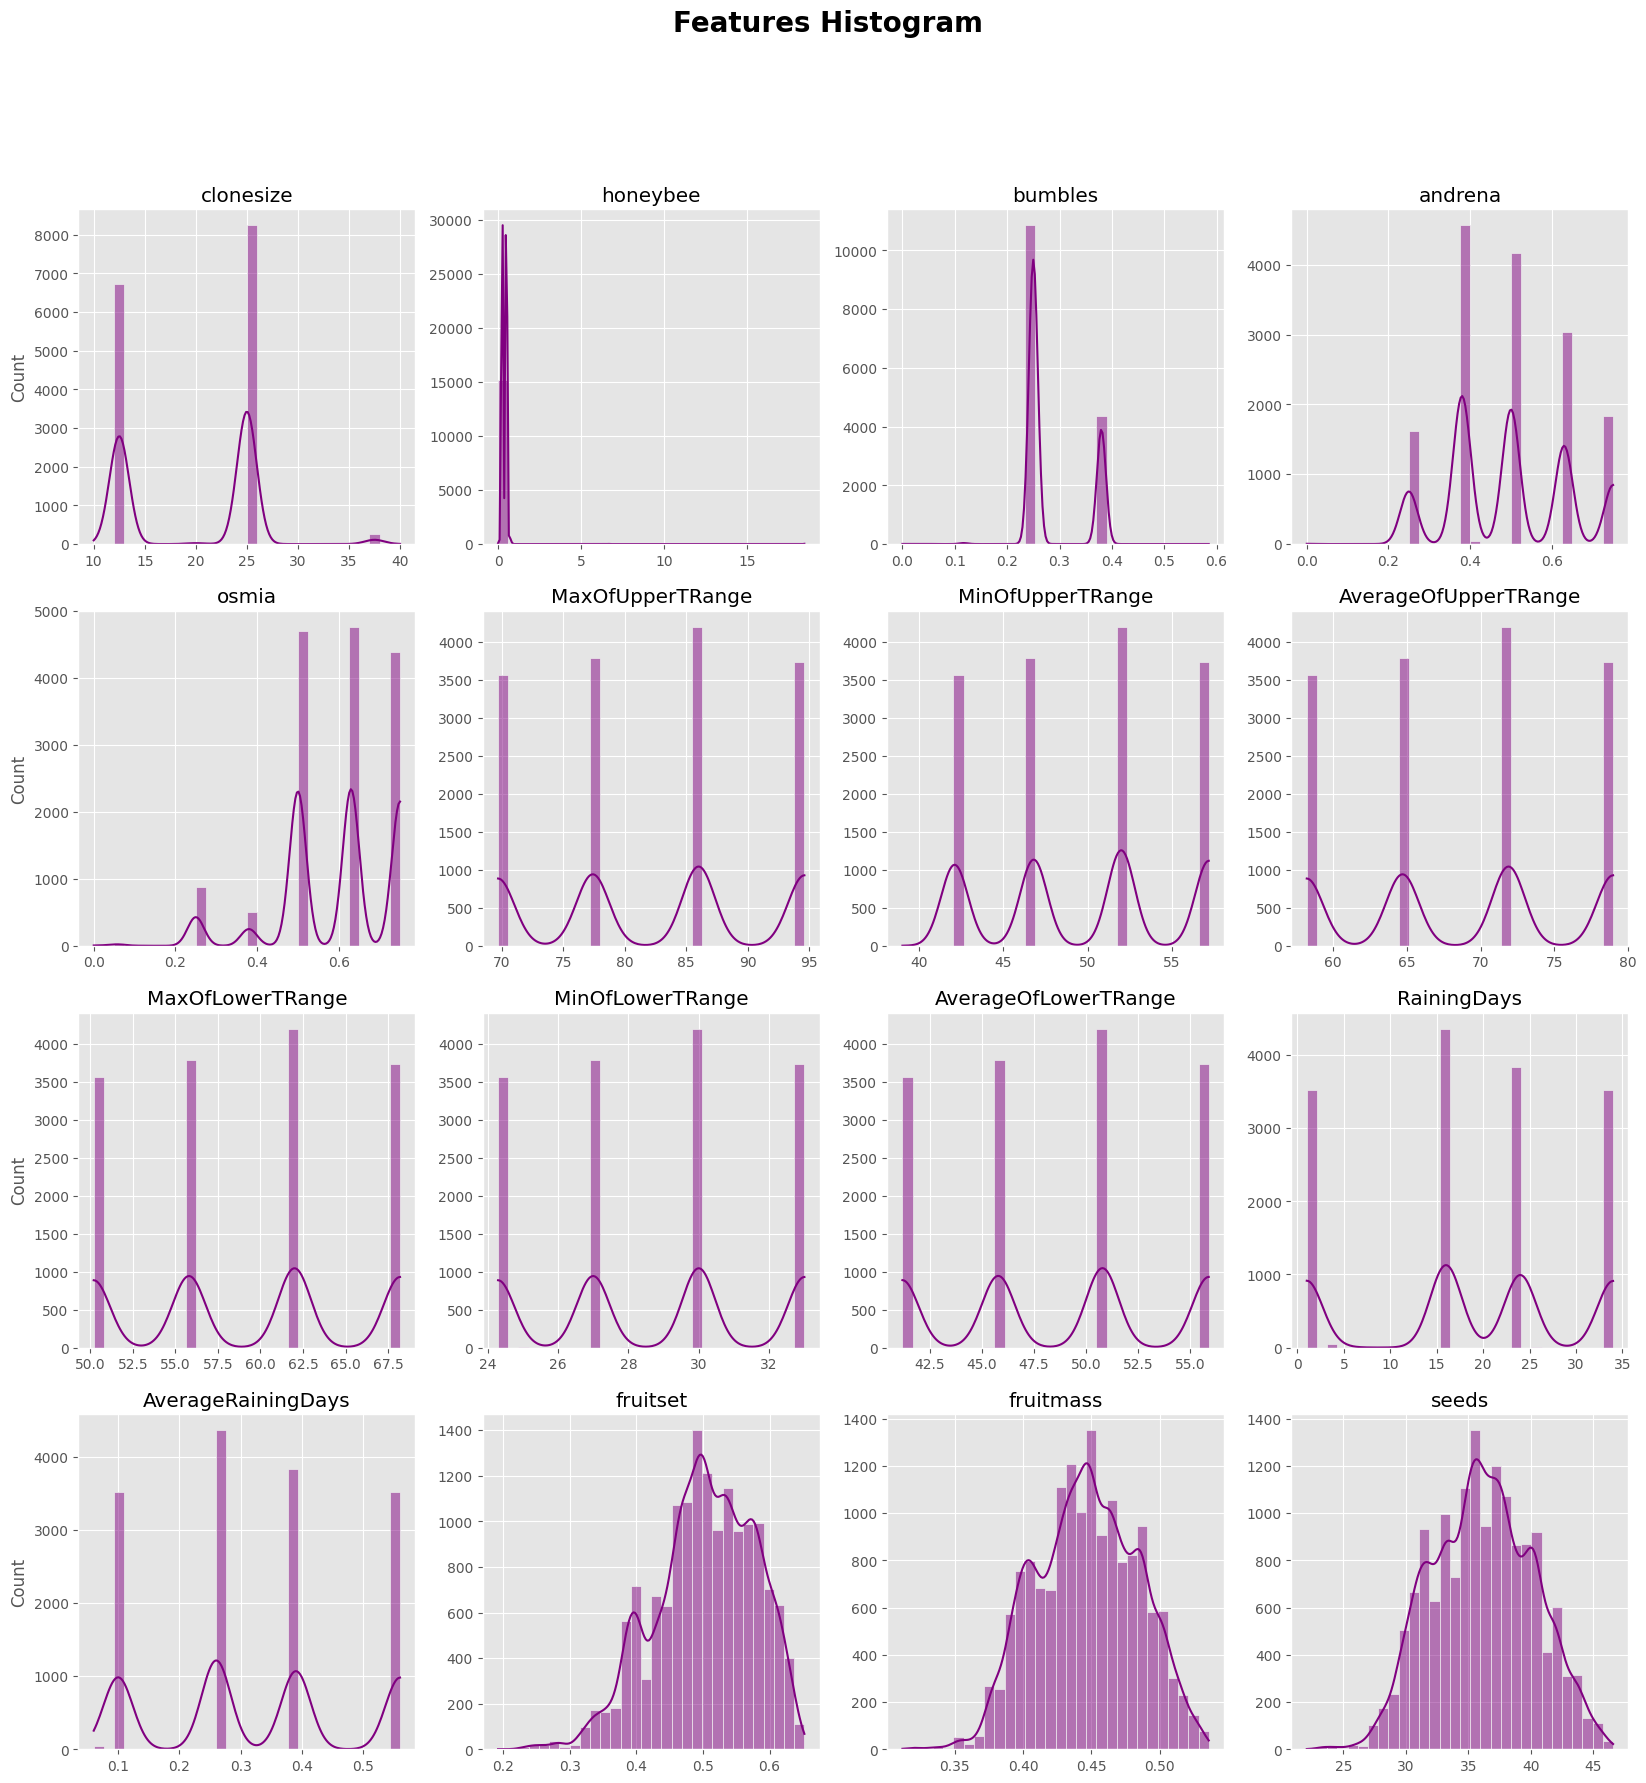

In [6]:
fig,ax = plt.subplots(ncols = 4, nrows = 4, figsize = (20,20))

features = list(df.columns)[:-1]

ax = ax.flatten()

for i,col in enumerate(features):
    
    sns.histplot(df[col], bins = 30, kde = True,
                ax = ax[i],
                color = 'purple')
    ax[i].set_title(col)
    ax[i].set_xlabel('')
    
    if i % 4 != 0:
        ax[i].set_ylabel('')
        
fig.suptitle('Features Histogram',
            fontsize = 20, weight = 'bold')

Text(0.5, 1.0, 'Target Histogram')

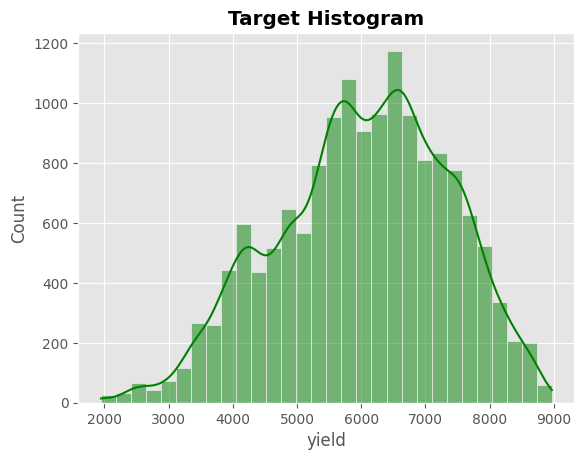

In [7]:
sns.histplot(data = df,
            x = 'yield',
            bins = 30,
            kde = True,
            color = 'green')
plt.title('Target Histogram',
         weight = 'bold')

# Correlationship

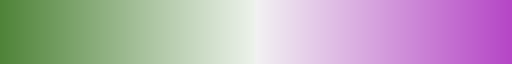

In [8]:
cmap = sns.diverging_palette(120,300,as_cmap = True)
cmap # make cmap for use correlationshpi heatmap

In [9]:
boundary = np.arange(-1,1,0.2)

norm = mpl.colors.BoundaryNorm(boundary, cmap.N)

Text(0.5, 0.98, 'Correlationship Heatmap')

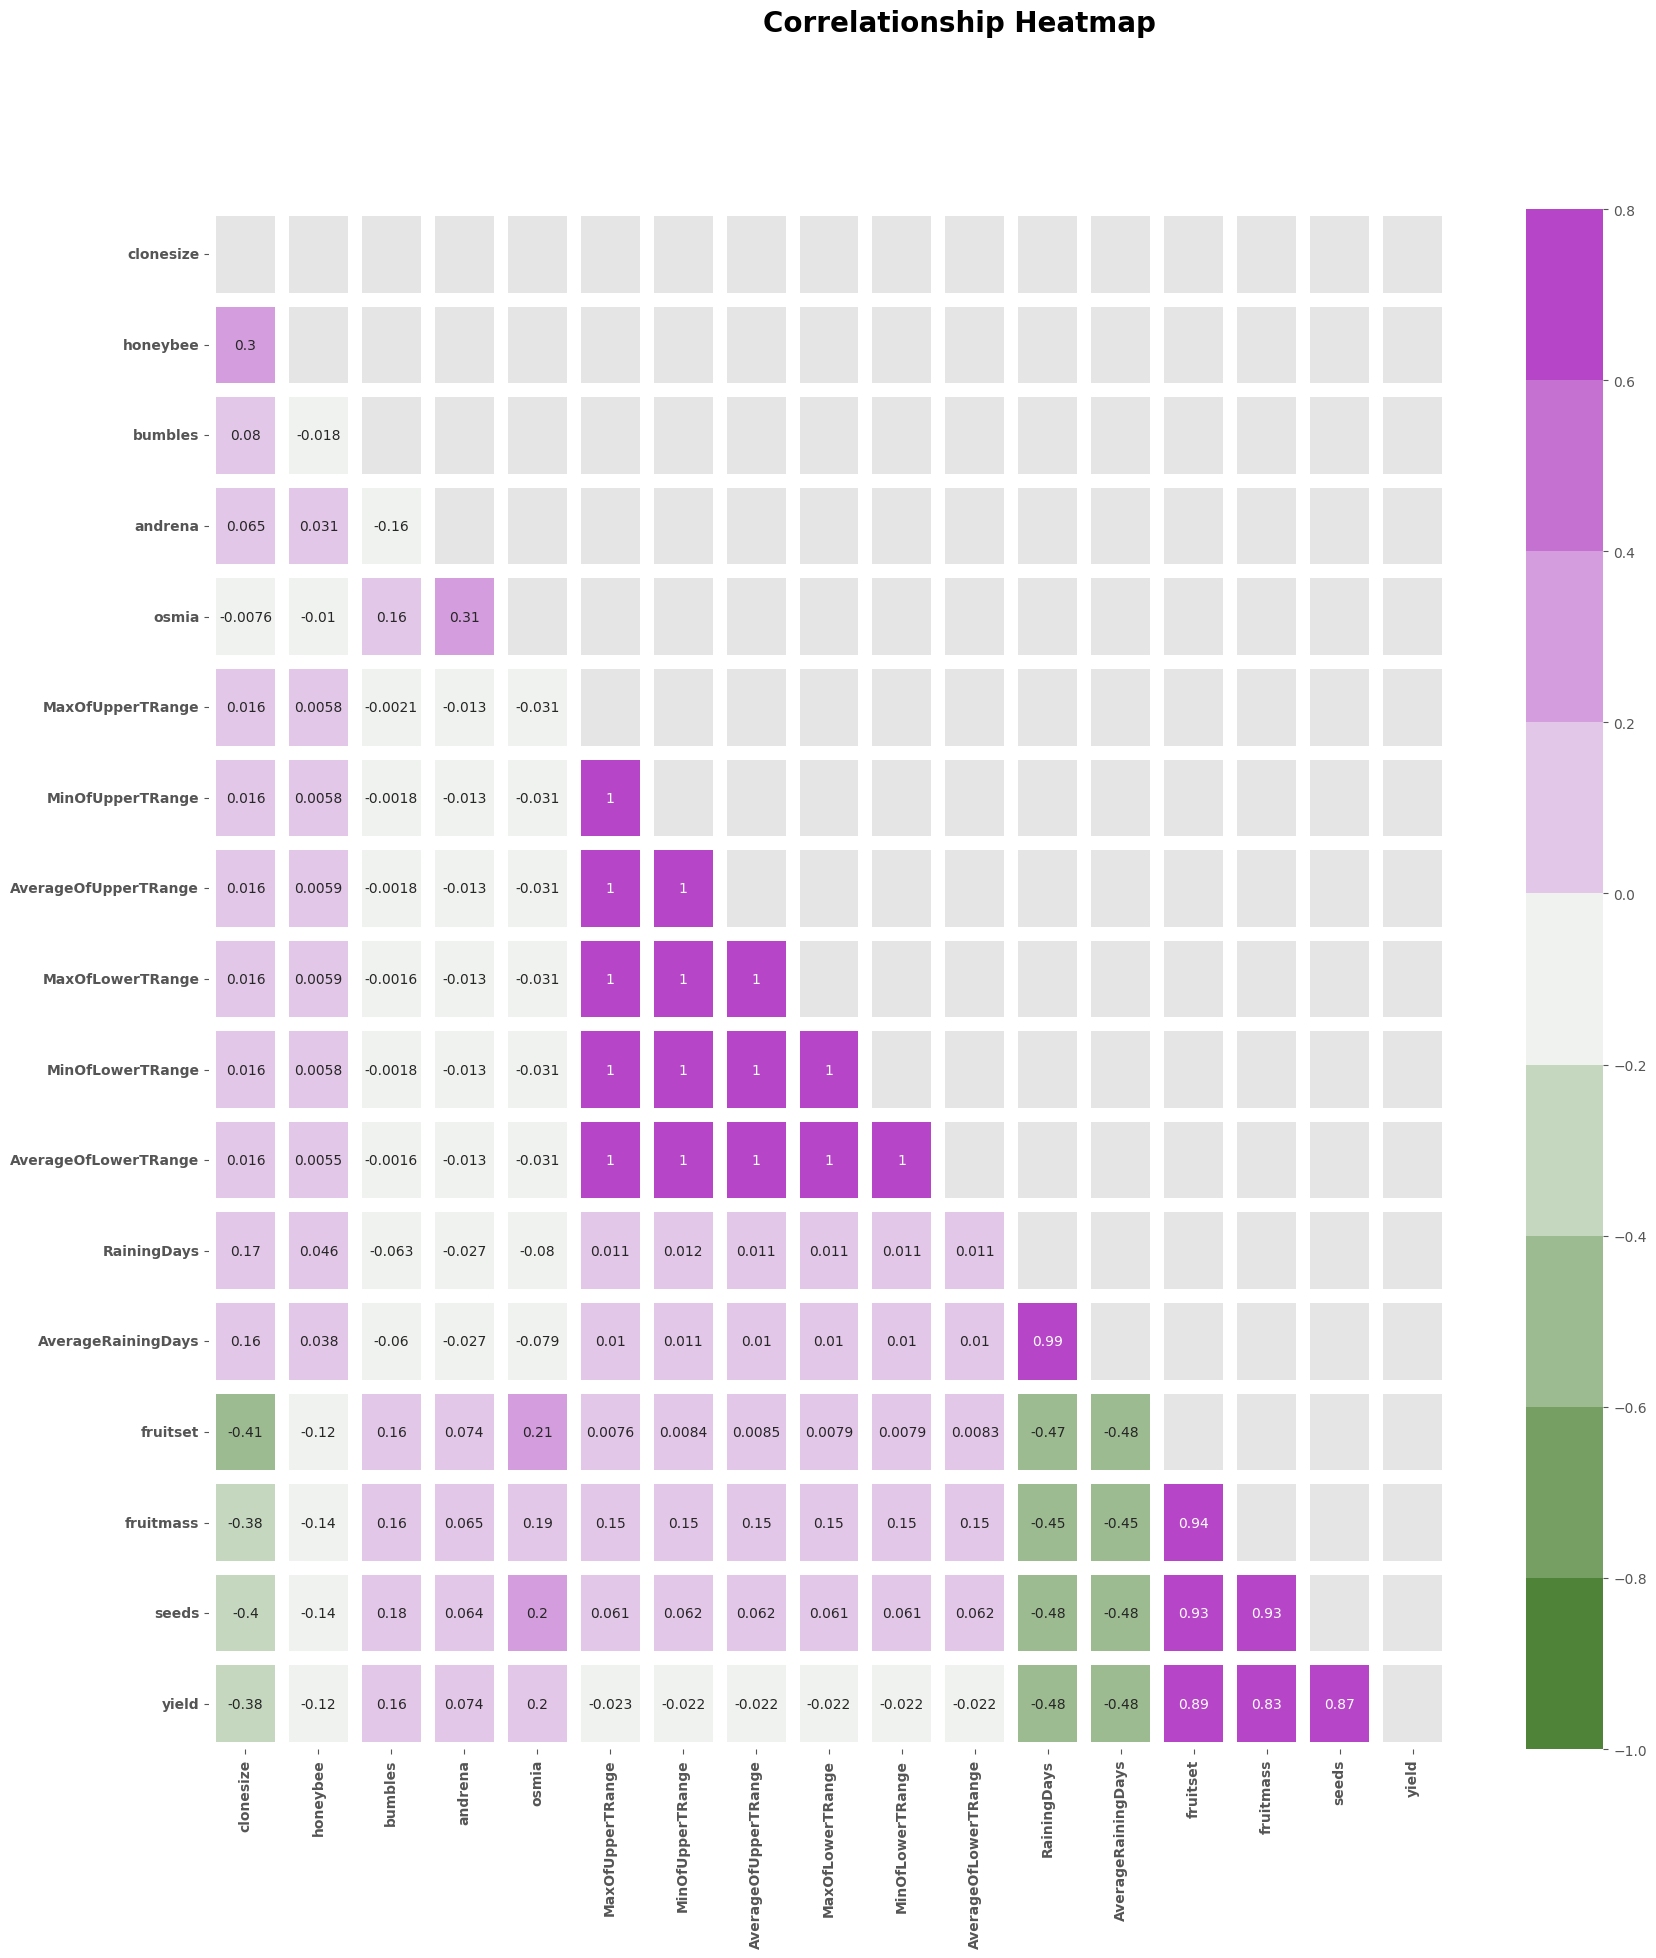

In [10]:
corr = df.corr()

mask = np.triu(np.ones_like(corr))

plt.figure(figsize = (20,20))

ax = sns.heatmap(corr, mask = mask, cmap = cmap, norm = norm,
            annot = True,linewidth = 10, fmt = '.2g')
ax.set_xticklabels(corr.index, weight = 'bold')
ax.set_yticklabels(corr.columns, weight = 'bold')

plt.suptitle('Correlationship Heatmap', fontsize = 20, fontweight = 'bold')

# Regplot

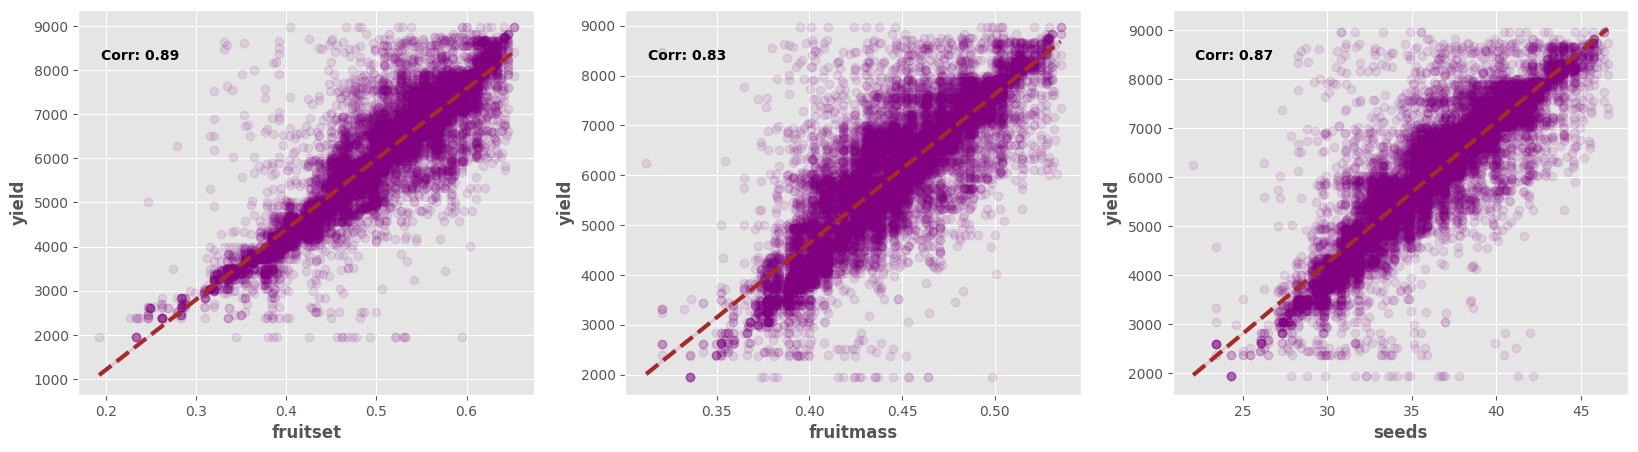

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
fig,ax = plt.subplots(ncols = 3, figsize = (20,5))
cols = ['fruitset','fruitmass','seeds']

for i,col in enumerate(cols):
    cor = round(df[['yield',col]].corr().iloc[0,1],2)
    sns.regplot(data = df,
                x = col,
                y = 'yield',
                ax = ax[i],
                scatter_kws = {'color':'purple',
                              'alpha':0.1},
                line_kws = {'color':'brown',
                            'ls':'--',
                            'lw':3})
    ax[i].set_xlabel(col, weight = 'bold')
    ax[i].set_ylabel('yield', weight = 'bold')
    ax[i].text(0.05, 0.90, f'Corr: {cor}', transform=ax[i].transAxes,
               fontdict={'family': 'DejaVu Sans', 'size': 10, 'weight': 'bold'},
               verticalalignment='top')

# Modeling

In [12]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,KFold
from sklearn.metrics import mean_absolute_error

In [13]:
X = df.drop('yield',axis = 1)
Y = df['yield']

x_train,x_test,y_train,y_test = train_test_split(X,Y, random_state = 42, test_size = 0.1)

In [14]:
model_params = {'n_estimators':500,
               'seed':42,
               'objective':'mae'}

param_grid = {
    'num_leaves': [30, 50, 100],
    'max_depth': [3, 5, 7],
    'min_child_samples': [10, 20, 30],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
}

model = LGBMRegressor(**model_params)
cv = KFold(n_splits = 10, shuffle = True, random_state = 42)

grid_lgbm = GridSearchCV(model, param_grid = param_grid, cv = cv,
                       scoring = 'neg_mean_absolute_error',verbose = 1)

grid_lgbm.fit(x_train,y_train)

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=LGBMRegressor(n_estimators=500, objective='mae',
                                     seed=42),
             param_grid={'max_depth': [3, 5, 7],
                         'min_child_samples': [10, 20, 30],
                         'num_leaves': [30, 50, 100],
                         'reg_alpha': [0, 0.1, 0.5],
                         'reg_lambda': [0, 0.1, 0.5]},
             scoring='neg_mean_absolute_error', verbose=1)

In [15]:
print('best parameter : ', grid_lgbm.best_params_)
print('best score : ', np.abs(grid_lgbm.best_score_))

best parameter :  {'max_depth': 7, 'min_child_samples': 20, 'num_leaves': 30, 'reg_alpha': 0.1, 'reg_lambda': 0}
best score :  342.81795560155877


In [16]:
result_model = grid_lgbm.best_estimator_
result_model

LGBMRegressor(max_depth=7, n_estimators=500, num_leaves=30, objective='mae',
              reg_alpha=0.1, reg_lambda=0, seed=42)

Text(0.5, 1.0, 'Actual VS predict \n MAE :334')

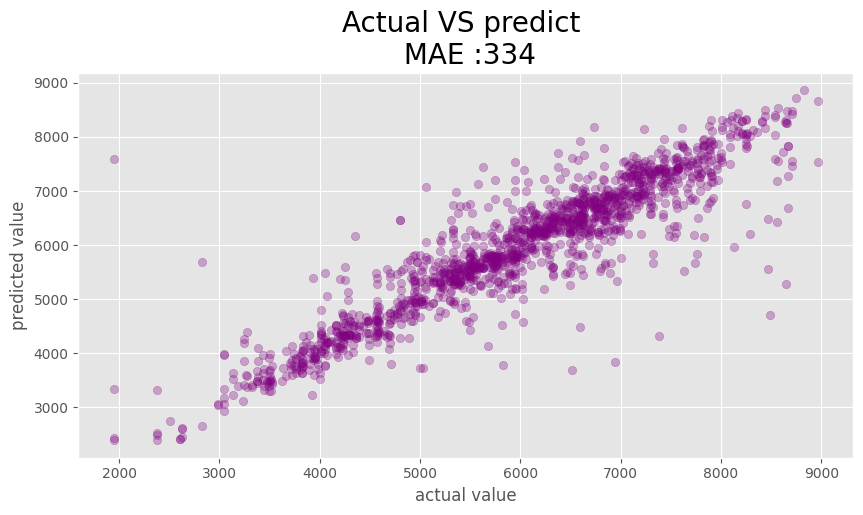

In [17]:
predicted = result_model.predict(x_test)

mae = round(mean_absolute_error(y_test,predicted))

plt.figure(figsize = (10,5))
plt.scatter(y_test,predicted, alpha = 0.3, color = 'purple')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.title(f'Actual VS predict \n MAE :{mae}', fontsize = 20)

Text(0.5, 1.0, 'Residual plot')

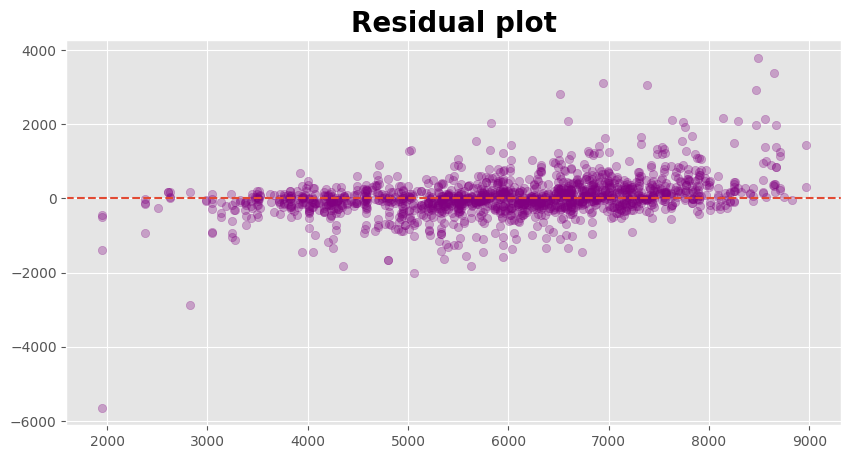

In [18]:
residual = y_test - predicted

plt.figure(figsize = (10,5))

plt.scatter(y_test,residual, alpha = 0.3, color = 'purple')
plt.axhline(0, ls ='--')
plt.title('Residual plot',fontsize = 20, weight = 'bold')

# Feature Importance

In [19]:
impt = pd.DataFrame({'cols':x_train.columns,
             'feature importance':result_model.feature_importances_})

impt = impt.sort_values(by = 'feature importance',
                                   ascending = False)

Text(0.5, 1.0, 'Feature Importance')

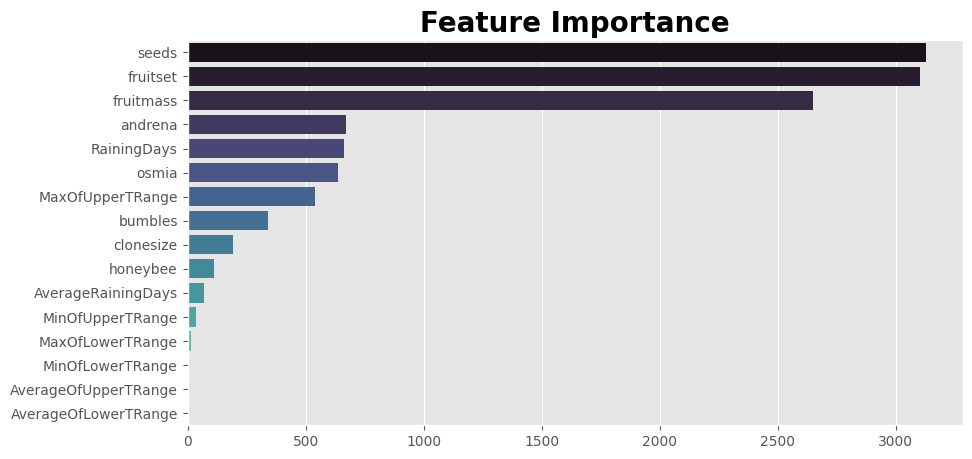

In [20]:
plt.figure(figsize = (10,5))

sns.barplot(data = impt,
           x = 'feature importance',
           y = 'cols',
           palette = 'mako')

plt.xlabel('')
plt.ylabel('')
plt.title('Feature Importance', fontsize= 20, weight = 'bold')

In [21]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e14/sample_submission.csv')

In [22]:
sub['yield'] = result_model.predict(test)

In [23]:
sub.head()

,id,yield
0,15289,4313.911492
1,15290,5937.447541
2,15291,7294.759748
3,15292,4586.808913
4,15293,3803.668191


In [24]:
sub.to_csv('submission.csv',index = False)

# Thx :)